In [24]:
%reset -f

In [25]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io as reader
from matplotlib import pyplot as plt 
import utils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
k = 1
a1 = 1
a2 = 4

rc1 = 0.5
rc2 = 0.3
rc3 = -0.5
rc4 = -0.3

In [27]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.iter = 0
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [28]:
def exact_u(x):
    return np.sin(a1 * np.pi * x[:, [0]]) * np.sin(a2 * np.pi * x[:, [1]])

In [29]:
def get_helmholtz_data(exact_u):
    x = np.expand_dims(np.linspace(-1, 1, 256), axis=1)
    t = np.expand_dims(np.linspace(-1, 1, 256), axis=1)
    X, T = np.meshgrid(x, t)
    x_test_np = np.concatenate(
        (np.vstack(np.expand_dims(X, axis=2)), 
         np.vstack(np.expand_dims(T, axis=2))), axis=-1)
    usol = exact_u(x_test_np)
    x = torch.from_numpy(x).float().to(device)
    t = torch.from_numpy(t).float().to(device)
    x_test = torch.from_numpy(x_test_np).float().to(device)
    x_test_exact = torch.from_numpy(usol).float().reshape(-1, 1).to(device)
    return x, t, x_test, x_test_exact

In [30]:
x, t, x_test_point, x_test_exact = get_helmholtz_data(exact_u)
Exact = x_test_exact.cpu().detach().numpy().reshape(256, 256)

In [31]:
# if error < self.top1:
#     self.top1 = error
#     torch.save(self.net.state_dict(), './best_model.pth')
# 载入best_model.pth
net = Net([2, 20, 20, 20, 20, 1]).to(device)
net.load_state_dict(torch.load('./best_model.pth'))

<All keys matched successfully>

In [32]:
from pyDOE import lhs
lb = np.array([-1.0, -1.0])
ub = np.array([1.0, 1.0])
def random_fun(num):
    temp = torch.from_numpy(lb + (ub - lb) * lhs(2, num)).float().to(device)
    return temp

In [33]:
imgl = net(x_test_point).reshape([256,256]).cpu()

In [34]:
j0 = 0
J = 5
e = 0.01

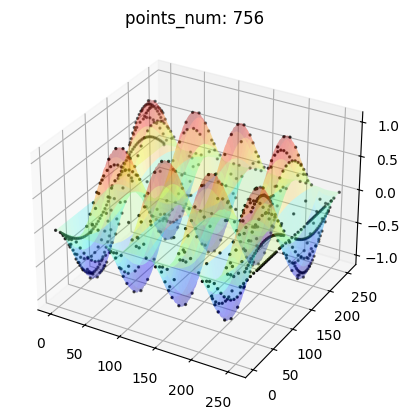

<Figure size 640x480 with 0 Axes>

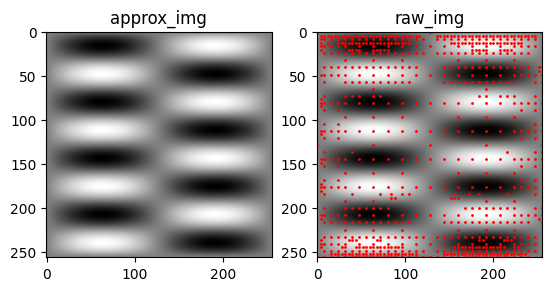

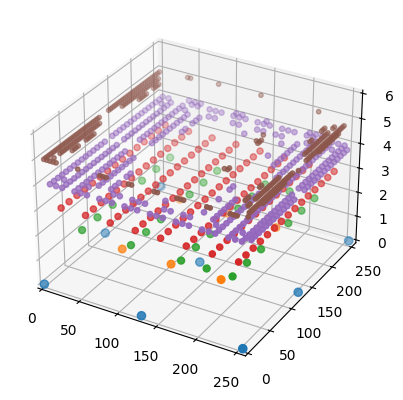

In [35]:
xc1 = torch.arange(lb[1], ub[1], 2/imgl.shape[0]).reshape((-1,1))
xr1 = torch.arange(lb[0], ub[0], 2/imgl.shape[1]).reshape((-1,1))
iwtmodel = utils.torchIWT(j0, J, e)
approx, indicies = iwtmodel.get_Iwt2d(imgl, xc1, xr1)
l=-1
utils.show_approx(imgl.cpu().detach().numpy(), approx.cpu().detach().numpy(), indicies, level_points=l, s=1, cmap='gray', show_2d_points=True, al=0.2)
utils.show_3d_points(approx.cpu().detach().numpy(), indicies, level_points=l)

In [36]:
err = np.linalg.norm(imgl.cpu().detach().numpy() - Exact, 2) / np.linalg.norm(Exact, 2) 
print('Relative L2 error: {:.4e}'.format(err))

Relative L2 error: 6.2430e-04


<Figure size 640x480 with 0 Axes>

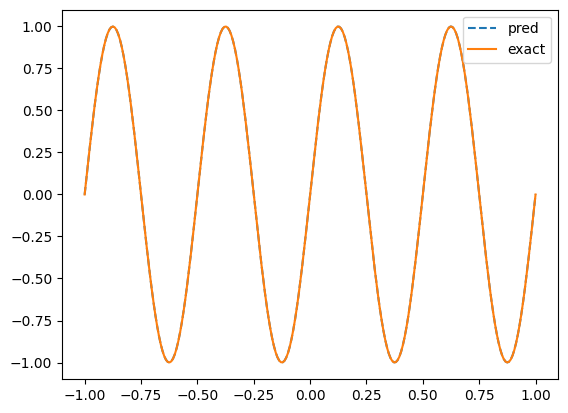

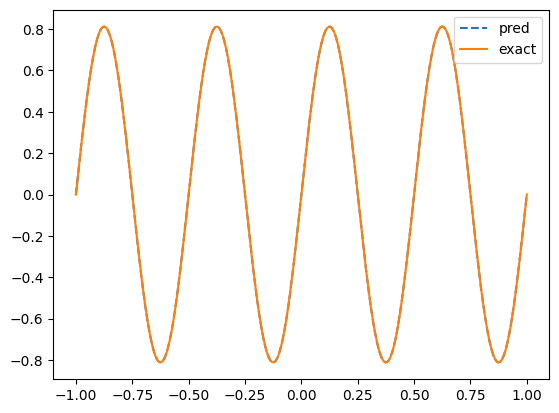

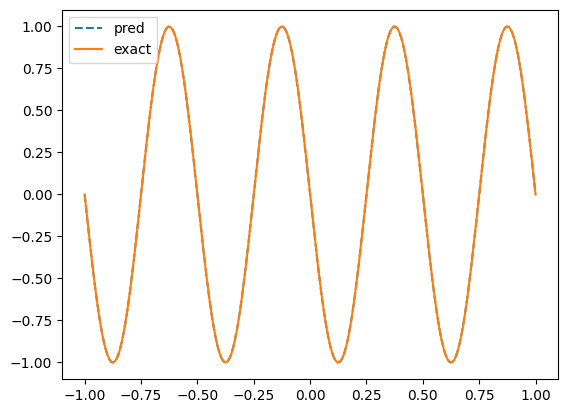

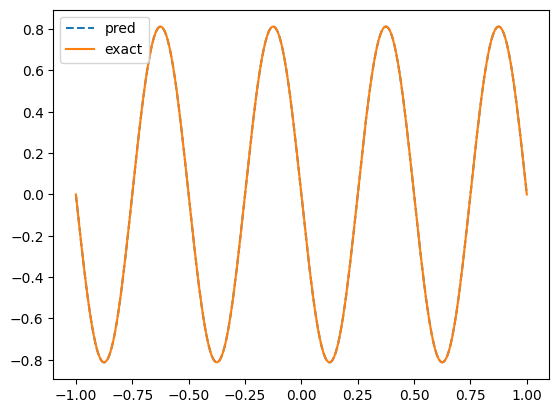

<Figure size 640x480 with 0 Axes>

In [37]:
x_test_pred = net(x_test_point)
x_test_pred = x_test_pred.reshape(x.shape[0], t.shape[0])
x_test_pred = x_test_pred.to('cpu').detach().numpy()
x_test_exact = x_test_exact.reshape(x.shape[0], t.shape[0])
x_test_exact = x_test_exact.to('cpu').detach().numpy()
x1 = x.to('cpu').detach().numpy()
t1 = t.to('cpu').detach().numpy()
plt.figure()
plt.plot(x1, x_test_pred[:, int((rc1 + 1) / (2 / 256))], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, int((rc1 + 1) / (2 / 256))], label='exact')
plt.legend()
plt.figure()
plt.plot(x1, x_test_pred[:, int((rc2 + 1) / (2 / 256))], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, int((rc2 + 1) / (2 / 256))], label='exact')
plt.legend()
plt.figure()
plt.plot(x1, x_test_pred[:, int((rc3 + 1) / (2 / 256))], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, int((rc3 + 1) / (2 / 256))], label='exact')
plt.legend()
plt.figure()
plt.plot(x1, x_test_pred[:, int((rc4 + 1) / (2 / 256))], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, int((rc4 + 1) / (2 / 256))], label='exact')
plt.legend()
plt.figure()

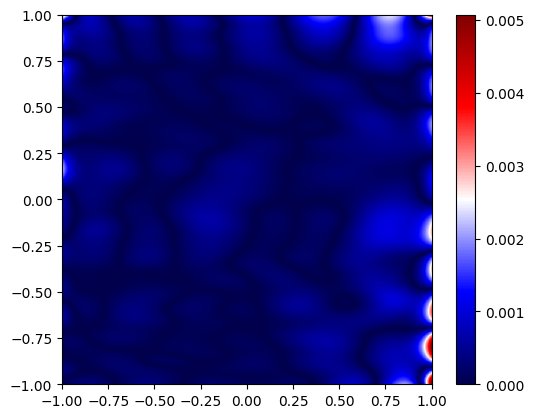

In [38]:
# error
plt.imshow(np.abs(x_test_pred - x_test_exact), extent=(-1, 1, -1, 1), cmap='seismic')
# 颜色条
plt.colorbar()
plt.show()